In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%pip install Augmentor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import zipfile
import Augmentor
from pathlib import Path
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, average_precision_score, accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import zipfile
import torch.nn.functional as F
import skimage.io as io
from matplotlib.pylab import plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import cv2
import sklearn
from sklearn.metrics import classification_report, accuracy_score, classification_report
from PIL import Image
from tqdm import tqdm






import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torchvision.transforms import ToTensor, Normalize, RandomHorizontalFlip
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split

In [4]:
torch.cuda.empty_cache()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Elastic Deformation

In [ ]:
#Train data
def Elastic_Deformation():
  #Create numerous samples of images and labels 

  p = Augmentor.Pipeline('/content/drive/MyDrive/ML Project/isbi_em_seg/images') #Images
  #p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
  #p.random_distortion(probability=1, grid_width=3, grid_height=3, magnitude=5)
  p.sample(100)

  s = Augmentor.Pipeline('/content/drive/MyDrive/ML Project/isbi_em_seg/labels') #Label
  #s.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  s.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
  #s.random_distortion(probability=1, grid_width=3, grid_height=3, magnitude=5)
  s.sample(100)


  #Change the name of image and labels
  location_images = '/content/drive/MyDrive/ML Project/isbi_em_seg/images/output'
  location_labels = '/content/drive/MyDrive/ML Project/isbi_em_seg/labels/output'

  files_images = os.listdir(location_images)
  files_labels = os.listdir(location_labels)
  i, j = 0, 0

  for file in files_images:
    if file.endswith('.jpg'):
      newname = 'train-volume' +str(i)+'.jpg'
      os.rename(os.path.join(location_images, file), os.path.join(location_images, newname))
      i+=1
  
  for file in files_labels:
    if file.endswith('.jpg'):
      newname = 'train-labels' +str(j)+'.jpg'
      os.rename(os.path.join(location_labels, file), os.path.join(location_labels, newname))
      j+=1
  



if __name__ == '__main__':
  Elastic_Deformation()

Initialised with 30 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/isbi_em_seg/images/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512 at 0x7F7771466610>: 100%|██████████| 100/100 [00:01<00:00, 67.61 Samples/s]


Initialised with 30 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/isbi_em_seg/labels/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=L size=512x512 at 0x7F777146D160>: 100%|██████████| 100/100 [00:01<00:00, 60.63 Samples/s]


In [6]:
class ISBIEMSegDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True, split=.8) -> None:
        self.root_dir = root_dir
        self.transform = transform

        self.path_images = os.path.join(self.root_dir, 'images')
        self.path_labels = os.path.join(self.root_dir, 'labels')

        self.image_paths = sorted(os.listdir(self.path_images))
        self.label_paths = sorted(os.listdir(self.path_labels))

        if train:
            self.image_paths = self.image_paths[:round(split*len(self.image_paths))]
            self.label_paths = self.label_paths[:round(split*len(self.label_paths))]
        else:
            self.image_paths = self.image_paths[round(split*len(self.image_paths)):]
            self.label_paths = self.label_paths[round(split*len(self.label_paths)):]


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):

        image = io.imread(os.path.join(self.path_images, self.image_paths[index])) 
        label = io.imread(os.path.join(self.path_labels, self.label_paths[index])) 

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # image = (image - self.mean) / self.std
        
        return image.float(), label.float()


In [7]:
def load_data(dataset='isbi_em_seg', transformation=None, n_train=None, n_test=None, batch_size=2):

    ds_reg = [
        'isbi_em_seg',
    ]

    if not dataset in ds_reg:
        print(f'Dataset not in registry, available datasets are: {ds_reg}')
    else:
        if not transformation:
            transformation = ToTensor()
        else:
            transformation = torch.nn.Sequential(
                ToTensor(),
                transformation
            )

        train_set = ISBIEMSegDataset(f'/content/drive/MyDrive/ML Project/{dataset}', transform=transformation, train=True, split=0.8)  
        test_set = ISBIEMSegDataset(f'/content/drive/MyDrive/ML Project/{dataset}', transform=transformation, train=False, split=0.8)

        return DataLoader(train_set, batch_size=batch_size), DataLoader(test_set, batch_size=batch_size)      

if __name__ == '__main__':
  
  train_set, test_set = load_data()
  print(len(train_set), len(test_set)) 

12 3


## Architecture

In [8]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DownBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 'same', padding_mode = 'reflect')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 'same', padding_mode = 'reflect')
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        h = x.clone()

        x = F.max_pool2d(x, kernel_size=2, stride=2)

        return x, h

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(UpBlock, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 'same', padding_mode = 'reflect')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 'same', padding_mode = 'reflect')
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, h):
        x = self.up_conv(x)
        c = self.crop(h, h.shape[2], x.shape[2])
        x = torch.cat((c, x), dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        return x

    def crop(self, x, in_size, out_size):
        start = int((in_size - out_size)/2)
        stop  = int((in_size + out_size)/2)

        return x[:,:,start:stop,start:stop]


class NewUNet(nn.Module):
    def __init__(self, in_channel) -> None:
        super(NewUNet, self).__init__()
        self.down_block_1 = DownBlock(in_channels=in_channel, out_channels=64)
        self.down_block_2 = DownBlock(in_channels=64, out_channels=128)
        self.down_block_3 = DownBlock(in_channels=128, out_channels=256)
        self.down_block_4 = DownBlock(in_channels=256, out_channels=512)

        self.middle_conv_1 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding = 'same', padding_mode = 'reflect')
        self.middle_conv_2 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding = 'same', padding_mode = 'reflect')

        self.up_block_1 = UpBlock(in_channels=1024, out_channels=512)
        self.up_block_2 = UpBlock(in_channels=512, out_channels=256)
        self.up_block_3 = UpBlock(in_channels=256, out_channels=128)
        self.up_block_4 = UpBlock(in_channels=128, out_channels=64)

        self.out_conv = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)

    def forward(self, x):
        x, h_1 = self.down_block_1(x)
        x, h_2 = self.down_block_2(x)
        x, h_3 = self.down_block_3(x)
        x, h_4 = self.down_block_4(x)

        x = self.middle_conv_1(x)
        x = self.middle_conv_2(x)

        x = self.up_block_1(x, h_4)
        x = self.up_block_2(x, h_3)
        x = self.up_block_3(x, h_2)
        x = self.up_block_4(x, h_1)

        x = self.out_conv(x)

        return x


def build_model():
    
    model = NewUNet()

    return model

if __name__ == '__main__':
    # model = build_model()
    model = NewUNet(1)

    X = torch.rand(1, 1, 512, 512)
    X = model(X)

    print(X.shape)

torch.Size([1, 2, 512, 512])


### Entropy Loss

In [9]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final

### Metrics

In [10]:
def calculate_iou(y, t):
    y = (y > 0.5).to(torch.float32)
    t = t.round()
    
    intersection = (y * t).sum((2, 3))
    union = ((y + t) >= 1).to(torch.float32).sum((2, 3))

    return (intersection / union).mean()

### Train & Test

In [11]:
def get_test_metrics(model, test_loader, criterion, device):
   losses, ious, confidences = [], [], []
   with torch.no_grad():
      for i, data in enumerate(test_loader):

         image, mask = data[0].to(device), data[1].to(device)
         output = model(image)
         output = output[:,1].unsqueeze(dim=1)
         
         loss = criterion(output, mask)
         losses.append(loss.item())

         iou = calculate_iou(output, mask)
         ious.append(iou.item())

   return torch.tensor(losses).mean().cpu().numpy().astype(float), torch.tensor(ious).mean().cpu().numpy().astype(float)

def custom_loss(output, mask):
   return (output - mask).abs().mean(dim=(1,2,3)).mean()
   # return ((output - mask)**2).mean(dim=(1,2,3)).norm()

def test_model(model, test_loader, device):
   model.eval()

   predictions, confidences = [], []
   with torch.no_grad():
      for i, data in enumerate(tqdm(test_loader)):
         image, mask = data[0].to(device), data[1].to(device)
         output = model(image)

         probabilities = torch.softmax(output, dim=1)
         
         #Calculate confidence score
         confidence, index = torch.max(probabilities, dim=1)
         confidence_mean = torch.mean(confidence).item()


         confidences.append(confidence_mean)
         predictions.append(output)
         


   predictions = torch.cat(predictions, dim=0)
   confidences = np.array(confidences)

   return predictions, mask, confidences.mean()

def train_one_epoch(model, train_loader, optimizer, criterion, device):
   losses, ious = [], []
   for i, (image, mask) in enumerate(tqdm(train_loader, leave=False)):
      image, mask = image.to(device), mask.to(device)

      optimizer.zero_grad()

      output = model(image)
      output = output[:,1].unsqueeze(dim=1)

      loss = criterion(output, mask)
      iou = calculate_iou(output, mask)
      losses.append(loss.item())
      ious.append(iou.item())
      loss.backward()
      optimizer.step()

   avg_loss = torch.tensor(losses).mean().cpu().numpy().astype(float)
   avg_iou = torch.tensor(ious).mean().cpu().numpy().astype(float)
   return avg_loss, avg_iou
         
def train_model(model, train_loader, test_loader, optimizer, criterion, device, num_epoch = 100):
   model.train()

   avg_ious_train, avg_ious_test = [], []
   avg_losses_train, avg_losses_test = [], []

   for epoch in range(num_epoch): 
      avg_loss_train, avg_iou_train = train_one_epoch(model, train_loader, optimizer, criterion, device)
      avg_loss_test, avg_iou_test = get_test_metrics(model, test_loader, criterion, device)

      avg_ious_train.append(avg_iou_train)
      avg_ious_test.append(avg_iou_test)
      avg_losses_train.append(avg_loss_train)
      avg_losses_test.append(avg_loss_test)
      print("Epoch {0}: train_loss {1} \t train_score {2} \t test_loss {3} \t test_score{4}".format(epoch, avg_loss_train, avg_iou_train, avg_loss_test, avg_iou_test))
      
   plt.figure(figsize=(25,5))
   plt.plot(avg_losses_train, label='Training Loss')
   plt.plot(avg_ious_train, label='Training IoU')
   plt.plot(avg_losses_test, label='Testing Loss')
   plt.plot(avg_ious_test, label='Testing IoU')
   plt.xlabel('epochs')
   plt.ylabel('Avg Loss & Score')
   plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
   plt.title('Train Loss & Train Score')
   plt.legend(loc='best')
   plt.grid(visible=True, which='both')
   plt.show()

In [12]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        bce_weight = 0.5
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        loss_final = BCE * bce_weight + dice_loss * (1 - bce_weight)
        return loss_final

def train_apply(method = 'train_model',dataset = 'isbi_em_seg', num_epochs=25, lr=0.01, momentum=0.99, batch_size=3):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Running on: {device}")

    train_loader, test_loader = load_data(dataset=dataset, batch_size=batch_size)
    model = NewUNet(1).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)   
    criterion = DiceBCELoss()

    eval(f'{method}(model, train_loader, test_loader, optimizer, criterion, device, num_epoch={num_epochs})')
    torch.save(model, '/content/drive/MyDrive/ML Project/isbi_em_seg/model.pt')

    predictions, mask, confidence_score = test_model(model, test_loader, device)

    return predictions, mask, confidence_score

def predict(learning_rate=0.01, epochs=25, batch_size=3, momentum=0.99):
    predictions, mask, confidence_score = train_apply(lr=learning_rate, num_epochs=epochs, batch_size=batch_size, momentum=momentum)
    print("Confidence score: ", confidence_score)

    prediction_test = predictions#[:, 1:2, :, :]
    mask_test = mask


    #Final Result
    fig = plt.figure(figsize=(20,20))
    for i in range (len(prediction_test)):
      while i < 2:

        predict_results = prediction_test[i].cpu().numpy()
        mask_results = mask_test[i].cpu().numpy()


        #predict_results = (predict_results * 255.0).astype("uint8")
        #mask_results = (mask_results * 255.0).astype("uint8")

        predict_results = predict_results[0]
        mask_results = mask_results[0]

        predict_results = predict_results.squeeze()
        mask_results = mask_results.squeeze()

        plt.subplot(5,2,2*i+1)
        plt.imshow(mask_results, cmap = 'gray')
        plt.axis("off")
        plt.subplot(5,2,2*i+2)
        plt.imshow(predict_results, cmap = 'gray') 
        plt.axis("off")
        i+=1
    plt.show()

## Prediction Results

Running on: cuda:0


Epoch 0: train_loss 0.32883360981941223 	 train_score 0.6551775932312012 	 test_loss 0.23122452199459076 	 test_score0.8081348538398743


Epoch 1: train_loss 0.26076850295066833 	 train_score 0.7866203188896179 	 test_loss 0.22822141647338867 	 test_score0.8512415885925293


Epoch 2: train_loss 0.24232129752635956 	 train_score 0.8374152779579163 	 test_loss 0.23423884809017181 	 test_score0.8545225262641907


Epoch 3: train_loss 0.22892040014266968 	 train_score 0.8513419032096863 	 test_loss 0.19570505619049072 	 test_score0.8842514157295227


Epoch 4: train_loss 0.2150580734014511 	 train_score 0.8641347885131836 	 test_loss 0.1994258612394333 	 test_score0.8769257664680481


Epoch 5: train_loss 0.2002851516008377 	 train_score 0.8709964156150818 	 test_loss 0.18667300045490265 	 test_score0.8873926997184753


Epoch 6: train_loss 0.19739599525928497 	 train_score 0.874347448348999 	 test_loss 0.1795215606689453 	 test_score0.8891114592552185


Epoch 7: train_loss 0.18701738119125366 	 train_score 0.881040096282959 	 test_loss 0.1759825348854065 	 test_score0.8903372883796692


Epoch 8: train_loss 0.17661941051483154 	 train_score 0.8837228417396545 	 test_loss 0.1648080199956894 	 test_score0.8956344127655029


Epoch 9: train_loss 0.1716645509004593 	 train_score 0.8873224854469299 	 test_loss 0.16662229597568512 	 test_score0.8936517834663391


Epoch 10: train_loss 0.16618435084819794 	 train_score 0.892366886138916 	 test_loss 0.16242407262325287 	 test_score0.8958332538604736


Epoch 11: train_loss 0.15888535976409912 	 train_score 0.8915583491325378 	 test_loss 0.15670649707317352 	 test_score0.8970088958740234


Epoch 12: train_loss 0.15258143842220306 	 train_score 0.8978674411773682 	 test_loss 0.15047381818294525 	 test_score0.9002006649971008


Epoch 13: train_loss 0.15016745030879974 	 train_score 0.895621120929718 	 test_loss 0.15553270280361176 	 test_score0.8937370181083679


Epoch 14: train_loss 0.14562682807445526 	 train_score 0.8993320465087891 	 test_loss 0.14789839088916779 	 test_score0.9004873633384705


Epoch 15: train_loss 0.14310595393180847 	 train_score 0.9012442231178284 	 test_loss 0.150098517537117 	 test_score0.896592915058136


Epoch 16: train_loss 0.13869686424732208 	 train_score 0.9024124145507812 	 test_loss 0.14699219167232513 	 test_score0.8999080657958984


Epoch 17: train_loss 0.1353350281715393 	 train_score 0.9048283696174622 	 test_loss 0.15353386104106903 	 test_score0.8981499075889587


Epoch 18: train_loss 0.13213545083999634 	 train_score 0.9079254269599915 	 test_loss 0.1453137844800949 	 test_score0.9016604423522949


Epoch 19: train_loss 0.1289740651845932 	 train_score 0.9082081317901611 	 test_loss 0.16153810918331146 	 test_score0.8992605805397034


Epoch 20: train_loss 0.1281479150056839 	 train_score 0.9088264107704163 	 test_loss 0.1517227739095688 	 test_score0.9007779955863953


Epoch 21: train_loss 0.12781570851802826 	 train_score 0.9085600972175598 	 test_loss 0.1893751174211502 	 test_score0.8976953029632568


Epoch 22: train_loss 0.12867696583271027 	 train_score 0.9077174067497253 	 test_loss 0.1517450362443924 	 test_score0.9015088677406311


Epoch 23: train_loss 0.12539175152778625 	 train_score 0.9068596959114075 	 test_loss 0.17511749267578125 	 test_score0.8946135640144348


Epoch 24: train_loss 0.12125274538993835 	 train_score 0.9120598435401917 	 test_loss 0.16582149267196655 	 test_score0.9046241641044617


Epoch 25: train_loss 0.11967385560274124 	 train_score 0.914437472820282 	 test_loss 0.1613015979528427 	 test_score0.8982522487640381


Epoch 26: train_loss 0.11754318326711655 	 train_score 0.9141266345977783 	 test_loss 0.16648001968860626 	 test_score0.9000279307365417


Epoch 27: train_loss 0.11458628624677658 	 train_score 0.9170045256614685 	 test_loss 0.16177479922771454 	 test_score0.9005991816520691


Epoch 28: train_loss 0.11431670188903809 	 train_score 0.9173247218132019 	 test_loss 0.17585164308547974 	 test_score0.9009326100349426


Epoch 29: train_loss 0.11158853769302368 	 train_score 0.9181450009346008 	 test_loss 0.17334242165088654 	 test_score0.8967280387878418


Epoch 30: train_loss 0.10974857211112976 	 train_score 0.9194315075874329 	 test_loss 0.16796283423900604 	 test_score0.902675211429596


Epoch 31: train_loss 0.10824701935052872 	 train_score 0.9205107092857361 	 test_loss 0.1912679672241211 	 test_score0.8985605239868164


Epoch 32: train_loss 0.1066504716873169 	 train_score 0.9205699563026428 	 test_loss 0.2058405876159668 	 test_score0.8998673558235168


Epoch 33: train_loss 0.10446954518556595 	 train_score 0.9229274392127991 	 test_loss 0.19709394872188568 	 test_score0.9033336639404297


Epoch 34: train_loss 0.10339939594268799 	 train_score 0.9242594838142395 	 test_loss 0.2108154296875 	 test_score0.9010836482048035


Epoch 35: train_loss 0.10198263078927994 	 train_score 0.9241517186164856 	 test_loss 0.20566006004810333 	 test_score0.8994333148002625


Epoch 36: train_loss 0.10050829499959946 	 train_score 0.925380289554596 	 test_loss 0.20360791683197021 	 test_score0.9026669859886169


Epoch 37: train_loss 0.09923737496137619 	 train_score 0.926692008972168 	 test_loss 0.2187509536743164 	 test_score0.8989438414573669


Epoch 38: train_loss 0.0983973816037178 	 train_score 0.9268286824226379 	 test_loss 0.22955642640590668 	 test_score0.899224579334259


Epoch 39: train_loss 0.09674865007400513 	 train_score 0.9280207753181458 	 test_loss 0.22614288330078125 	 test_score0.9021559357643127


Epoch 40: train_loss 0.09651706367731094 	 train_score 0.9285731315612793 	 test_loss 0.23600073158740997 	 test_score0.8994442820549011


Epoch 41: train_loss 0.09515482932329178 	 train_score 0.9295515418052673 	 test_loss 0.222676619887352 	 test_score0.8999010920524597


Epoch 42: train_loss 0.09415627270936966 	 train_score 0.9300834536552429 	 test_loss 0.22671739757061005 	 test_score0.9022548198699951


Epoch 43: train_loss 0.09354142099618912 	 train_score 0.9312665462493896 	 test_loss 0.22196698188781738 	 test_score0.8992156982421875


Epoch 44: train_loss 0.09315842390060425 	 train_score 0.9312002062797546 	 test_loss 0.22218964993953705 	 test_score0.9008364081382751


Epoch 45: train_loss 0.0923696979880333 	 train_score 0.931101381778717 	 test_loss 0.21860617399215698 	 test_score0.9002953171730042


Epoch 46: train_loss 0.09171435981988907 	 train_score 0.9326973557472229 	 test_loss 0.23553740978240967 	 test_score0.8999660015106201


Epoch 47: train_loss 0.09132170677185059 	 train_score 0.9325850009918213 	 test_loss 0.2472728043794632 	 test_score0.8972412943840027


Epoch 48: train_loss 0.09191647917032242 	 train_score 0.9316167831420898 	 test_loss 0.24001722037792206 	 test_score0.901707649230957


Epoch 49: train_loss 0.09111858159303665 	 train_score 0.9329965114593506 	 test_loss 0.20391857624053955 	 test_score0.8970904350280762


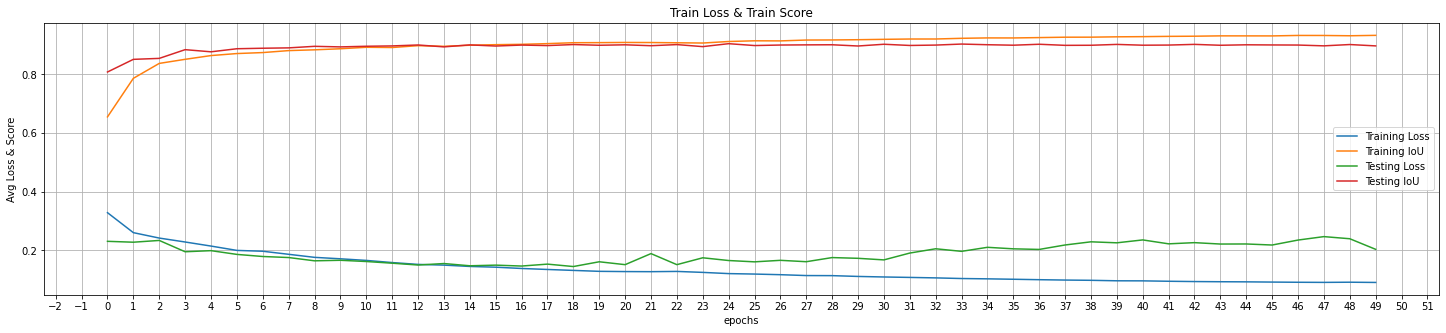

100%|██████████| 3/3 [00:00<00:00,  4.66it/s]
<ipython-input-12-13121ebde673>:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5,2,2*i+1)
<ipython-input-12-13121ebde673>:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5,2,2*i+2)


Confidence score:  0.9612003366152445


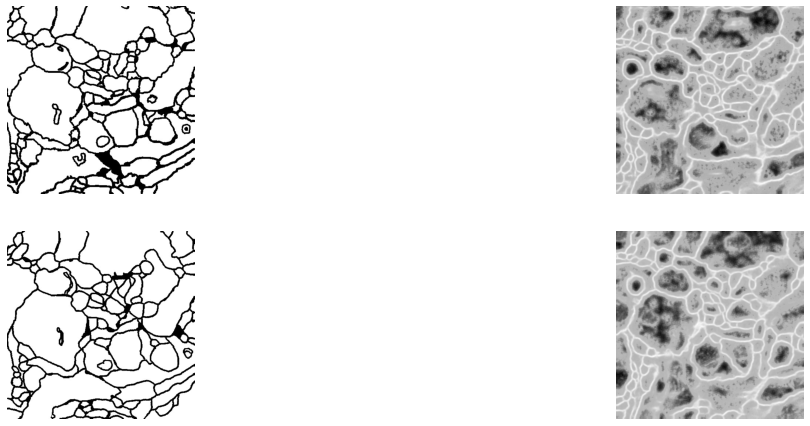

In [14]:
NUM_EPOCHS = 50
LR = 0.07
MOMENTUM = 0.99
BATCH_SIZE = 2

#predictions, mask, confidence_score = train_apply(lr=LR, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, momentum=MOMENTUM)
#print(predictions.shape)

predict(learning_rate=LR, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, momentum=MOMENTUM)